# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Data-Pre-Processing" data-toc-modified-id="Data-Pre-Processing-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data Pre-Processing</a></div><div class="lev2 toc-item"><a href="#Load-Data" data-toc-modified-id="Load-Data-11"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Load Data</a></div><div class="lev2 toc-item"><a href="#Word-Segmentation" data-toc-modified-id="Word-Segmentation-12"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Word Segmentation</a></div><div class="lev2 toc-item"><a href="#Explore-the-Data" data-toc-modified-id="Explore-the-Data-13"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Explore the Data</a></div><div class="lev1 toc-item"><a href="#Word-Embedding" data-toc-modified-id="Word-Embedding-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Word Embedding</a></div><div class="lev2 toc-item"><a href="#Tokenize-Text" data-toc-modified-id="Tokenize-Text-21"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Tokenize Text</a></div><div class="lev2 toc-item"><a href="#Create-Word-Embeddings-with-GloVe" data-toc-modified-id="Create-Word-Embeddings-with-GloVe-22"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Create Word Embeddings with GloVe</a></div><div class="lev3 toc-item"><a href="#Read-Glove" data-toc-modified-id="Read-Glove-221"><span class="toc-item-num">2.2.1&nbsp;&nbsp;</span>Read Glove</a></div><div class="lev3 toc-item"><a href="#Use-Glove-to-Initialize-Embedding-Matrix" data-toc-modified-id="Use-Glove-to-Initialize-Embedding-Matrix-222"><span class="toc-item-num">2.2.2&nbsp;&nbsp;</span>Use Glove to Initialize Embedding Matrix</a></div><div class="lev1 toc-item"><a href="#Build-Dateset" data-toc-modified-id="Build-Dateset-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Build Dateset</a></div><div class="lev1 toc-item"><a href="#Save-Dataset" data-toc-modified-id="Save-Dataset-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Save Dataset</a></div><div class="lev1 toc-item"><a href="#Checkpoint" data-toc-modified-id="Checkpoint-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Checkpoint</a></div><div class="lev1 toc-item"><a href="#Build-Model" data-toc-modified-id="Build-Model-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Build Model</a></div><div class="lev2 toc-item"><a href="#Set-Hyperparameters" data-toc-modified-id="Set-Hyperparameters-61"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Set Hyperparameters</a></div><div class="lev2 toc-item"><a href="#Import-Libraries" data-toc-modified-id="Import-Libraries-62"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Import Libraries</a></div><div class="lev2 toc-item"><a href="#Model-Visualization" data-toc-modified-id="Model-Visualization-63"><span class="toc-item-num">6.3&nbsp;&nbsp;</span>Model Visualization</a></div><div class="lev2 toc-item"><a href="#Train" data-toc-modified-id="Train-64"><span class="toc-item-num">6.4&nbsp;&nbsp;</span>Train</a></div><div class="lev1 toc-item"><a href="#Evaluate" data-toc-modified-id="Evaluate-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Evaluate</a></div><div class="lev2 toc-item"><a href="#Experiment-1" data-toc-modified-id="Experiment-1-71"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>Experiment 1</a></div><div class="lev2 toc-item"><a href="#Experiment-2" data-toc-modified-id="Experiment-2-72"><span class="toc-item-num">7.2&nbsp;&nbsp;</span>Experiment 2</a></div><div class="lev2 toc-item"><a href="#Experiment-3" data-toc-modified-id="Experiment-3-73"><span class="toc-item-num">7.3&nbsp;&nbsp;</span>Experiment 3</a></div>

#  Data Pre-Processing

## Load Data

In [1]:
import os

In [2]:
def load_data(path):
    """
    Load date from file
    """
    input_file = os.path.join(path)
    with open(input_file, 'r', encoding='utf-8') as f:
        return f.read()

In [3]:
train_data_path = 'train_data.txt'
train_data = load_data(train_data_path).strip().split('\t')[1:]
train_data = [line.split('\n')[:2] for line in train_data]
test_data_path = 'test_data.txt'
test_data = load_data(test_data_path).strip().split('\t')[1:]
test_data = [line.split('\n')[:2] for line in test_data]

In [4]:
train_sent = [line[0] for line in train_data]
test_sent = [line[0] for line in test_data]
train_label = ['Causal' if line[-1] == 'Cause-Effect(e2,e1)' or line[-1] == 'Cause-Effect(e1,e2)' else 'Non-Causal' for line in train_data]
test_label = ['Causal' if line[-1] == 'Cause-Effect(e2,e1)' or line[-1] == 'Cause-Effect(e1,e2)' else 'Non-Causal' for line in test_data]

## Word Segmentation

In [5]:
from nltk import regexp_tokenize

In [6]:
filename = "stopwords.txt"
stopWords = {w: None for w in open(filename).read().split()}

In [7]:
def cut(s):
    """
    Word segmentation
    """
    pattern = r'''
              (?x)                   # set flag to allow verbose regexps 
              (?:[A-Z]\.)+           # abbreviations, e.g. U.S.A. 
              |\d+(?:\.\d+)?%?       # numbers, incl. currency and percentages 
              |\w+(?:[-&']\w+)*      # words w/ optional internal hyphens/apostrophe 
           '''  
    return regexp_tokenize(s, pattern=pattern)

def find_pn(ws):
    """
    Find paired nominals
    """
    for i in range(len(ws)):
        if ws[i] == 'e1':
            for j in range(i+1, len(ws)):
                if ws[j] == 'e1':
                    pn1 = ws[i+1:j] 
        if ws[i] == 'e2':
            for j in range(i+1, len(ws)):
                if ws[j] == 'e2':
                    pn2 = ws[i+1:j]
    return pn1, pn2

def del_stop(ws):
    """
    Delete stopwords
    """
    return [i for i in [stopWords.get(i.lower(), i) for i in ws] if i != None]

In [8]:
trainWords = [cut(s) for s in train_sent] 
trainPn1 = [find_pn(ws)[0] for ws in trainWords] 
trainPn2 = [find_pn(ws)[-1] for ws in trainWords] 
#trainWords = [del_stop(ws) for ws in trainWords]
testWords = [cut(s) for s in test_sent] 
testPn1 = [find_pn(ws)[0] for ws in testWords] 
testPn2 = [find_pn(ws)[-1] for ws in testWords] 
#testWords = [del_stop(ws) for ws in testWords]

In [14]:
[[' '.join(trainWords[i])] for i in range(len(trainWords)) if train_label[i] == 'Causal']

[['The current view is that the chronic e1 inflammation e1 in the distal part of the stomach caused by Helicobacter pylori e2 infection e2 results in an increased acid production from the non-infected upper corpus region of the stomach'],
 ['The e1 burst e1 has been caused by water hammer e2 pressure e2'],
 ['The e1 singer e1 who performed three of the nominated songs also caused a e2 commotion e2 on the red carpet'],
 ['e1 Suicide e1 is one of the leading causes of e2 death e2 among pre-adolescents and teens and victims of bullying are at an increased risk for committing suicide'],
 ['He had chest pains and e1 headaches e1 from e2 mold e2 in the bedrooms'],
 ['Financial e1 stress e1 is one of the main causes of e2 divorce e2'],
 ['The e1 women e1 that caused the e2 accident e2 was on the cell phone and ran thru the intersection without pausing on the median'],
 ['e1 Calluses e1 are caused by improperly fitting shoes or by a e2 skin abnormality e2'],
 ['As in the popular movie Deep Imp

## Explore the Data

In [9]:
import numpy as np

In [10]:
' '.join(trainWords[8])

'lawsonite was contained a platinum crucible and counter-weight was a plastic crucible with metal pieces'

In [11]:
trainPn1[8], trainPn2[8]

(['lawsonite'], ['platinum', 'crucible'])

In [12]:
train_label[8]

'Non-Causal'

In [13]:
len([i for i in train_label if i == 'Causal']) 

1003

In [14]:
len([i for i in test_label if i == 'Causal'])

328

In [15]:
np.max([len(trainWords[i]) for i in range(len(train_label))])

74

In [16]:
np.max([len(testWords[i]) for i in range(len(test_label))])

48

In [17]:
np.max([len(trainWords[i]) for i in range(len(train_label)) if train_label[i] == 'Causal'])

45

In [18]:
np.max([len(testWords[i]) for i in range(len(test_label)) if test_label[i] == 'Causal'])

39

In [19]:
MAX_LEN = 45

# Word Embedding

##  Tokenize Text

In [20]:
from keras.preprocessing.text import Tokenizer

Using TensorFlow backend.


In [21]:
tokWords = trainWords.copy()
tokWords.extend(testWords)
tokTexts = [' '.join(i) for i in tokWords]
tokenizer = Tokenizer(filters='')
tokenizer.fit_on_texts(tokTexts)
word2index = tokenizer.word_index
index2word = {i: w for w, i in word2index.items()}
print('Found %s unique tokens.' % len(word2index))

Found 23594 unique tokens.


## Create Word Embeddings with GloVe

In [22]:
VOCAB_SIZE = 23595
EMBEDDING_SIZE = 300
SEED = 42

### Read Glove

In [23]:
glove_n_symbols = 1917495
glove_index_dict = {}
glove_embedding_weights = np.empty((glove_n_symbols, EMBEDDING_SIZE))
globale_scale = 0.1
with open('/Users/lizhn7/Downloads/DATA/Glove/glove.42B.300d.txt', 'r') as fp:
    index = 0
    for l in fp:
        l = l.strip().split()
        word = l[0]
        glove_index_dict[word] = index
        glove_embedding_weights[index, :] = [float(n) for n in l[1:]]
        index += 1
glove_embedding_weights *= globale_scale

### Use Glove to Initialize Embedding Matrix

In [24]:
from nltk import WordNetLemmatizer, PorterStemmer, LancasterStemmer

In [25]:
# Generate random embedding with same scale as glove
np.random.seed(SEED)
shape = (VOCAB_SIZE, EMBEDDING_SIZE)
scale = glove_embedding_weights.std() * np.sqrt(12) / 2 
embedding = np.random.uniform(low=-scale, high=scale, size=shape)

In [26]:
wnl = WordNetLemmatizer()
porter = PorterStemmer()
lancaster = LancasterStemmer()

In [27]:
# Copy from glove weights of words that appear in index2word
count = 0 
for i in range(1, VOCAB_SIZE):
    w = index2word[i]
    g = glove_index_dict.get(w)
    if g is None:
        w = wnl.lemmatize(w)
        g = glove_index_dict.get(w)
        if g is None:
            w = porter.stem(w)
            g = glove_index_dict.get(w)
            if g is None:
                w = lancaster.stem(w)
                g = glove_index_dict.get(w)
    if g is None:
        w = porter.stem(w)
        g = glove_index_dict.get(w)
    if g is None:
        w = lancaster.stem(w)
        g = glove_index_dict.get(w)
    if g is not None:
        embedding[i, :] = glove_embedding_weights[g, :]
        count += 1
print('{num_tokens}-{per:.2f}% tokens in vocab found in glove and copied to embedding.'.format(num_tokens=count, per=count/float(VOCAB_SIZE)*100))

22393-94.91% tokens in vocab found in glove and copied to embedding.


# Build Dateset

In [28]:
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

In [29]:
labelDict = {'Non-Causal': 0, 'Causal': 1}

In [30]:
def convert_seq(ws, label):
    """
    Pad words sequene to MAX_LEN and encode label to one-hot encoding
    """
    sentText = [' '.join(i) for i in ws]
    sentSeq = tokenizer.texts_to_sequences(sentText)
    sentData = pad_sequences(sentSeq, maxlen=MAX_LEN, padding='post', truncating='post')
    labelData = np.array([[labelDict[i]] for i in label])
    return sentData, labelData 

def convert_pn(pn):
    """
    Convert data to paired-nominals word vectors
    """
    pn = [[word2index[i.lower()] for i in p] for p in pn]
    pn = np.array([sum([embedding[i] for i in p]) for p in pn])
    return pn

In [31]:
xTrain, yTrain = convert_seq(trainWords, train_label)
xTest, yTest = convert_seq(testWords, test_label)
pn1_xTrain = convert_pn(trainPn1)
pn2_xTrain = convert_pn(trainPn2)
pn1_xTest = convert_pn(testPn1)
pn2_xTest = convert_pn(testPn2)

In [41]:
xTrain, _, yTrain, _ = train_test_split(xTrain, yTrain, test_size=0., random_state=SEED)
xTest, _, yTest, _ = train_test_split(xTest, yTest, test_size=0., random_state=SEED)
pn1_xTrain, _, pn2_xTrain, _ = train_test_split(pn1_xTrain, pn2_xTrain, test_size=0., random_state=SEED)
pn1_xTest, _, pn2_xTest, _ = train_test_split(pn1_xTest, pn2_xTest, test_size=0., random_state=SEED)

# Save Dataset

In [42]:
import h5py

In [44]:
fh = h5py.File('/Users/lizhn7/Downloads/DATA/semeval2010_task8_all_data/因果关系检测实验_1/allData.h5', 'w')
fh['xTrain'] = xTrain
fh['yTrain'] = yTrain
fh['xTest'] = xTest
fh['yTest'] = yTest
fh['pn1_xTrain'] = pn1_xTrain
fh['pn2_xTrain'] = pn2_xTrain
fh['pn1_xTest'] = pn1_xTest
fh['pn2_xTest'] = pn2_xTest
fh['embedding'] = embedding
fh.close()

# Checkpoint

In [45]:
import h5py

In [46]:
with h5py.File('/Users/lizhn7/Downloads/DATA/semeval2010_task8_all_data/因果关系检测实验_1/allData.h5', 'r') as fh:
    xTrain = fh['xTrain'][:]
    yTrain = fh['yTrain'][:]
    xTest = fh['xTest'][:]
    yTest = fh['yTest'][:]
    pn1_xTrain = fh['pn1_xTrain'][:]
    pn2_xTrain = fh['pn2_xTrain'][:]
    pn1_xTest = fh['pn1_xTest'][:]
    pn2_xTest = fh['pn2_xTest'][:]
    embedding = fh['embedding'][:]

# Build Model

## Set Hyperparameters

In [278]:
MAX_LEN = 45
VOCAB_SIZE = 23595
EMBEDDING_SIZE = 300
RNN_SIZE = 150
DROPOUT_RATE = 0.5
RNN_DROPOUT_RATE = 0.5
CNN_SIZE = 128
WINDOW_SIZE = 3
NUM_EPOCHS = 64
BATCH_SIZE = 32

## Import Libraries

In [279]:
from keras.layers import Input, Embedding, Dropout, Bidirectional, LSTM, Reshape, concatenate, Conv1D, BatchNormalization, GlobalMaxPooling1D, Dense
from keras.models import Model
import keras.backend as K
from keras.callbacks import*
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [280]:
K.clear_session()
seq = Input(shape=(MAX_LEN,), name='INPUT') 
emb_seq = Embedding(VOCAB_SIZE, EMBEDDING_SIZE, weights=[embedding], mask_zero=False, input_length=MAX_LEN, trainable=False, name='EMBEDDING')(seq)
blstm = Bidirectional(LSTM(RNN_SIZE, return_sequences=True, implementation=0, dropout=RNN_DROPOUT_RATE, recurrent_dropout=RNN_DROPOUT_RATE), merge_mode='concat', name='BiLSTM')(emb_seq)
blstm = Dropout(DROPOUT_RATE, name='DROPOUT_1')(blstm)
#blstm = BatchNormalization(axis=-1, name='BN_1')(blstm)
pn1 = Input(shape=(EMBEDDING_SIZE,), name='PN1_INPUT')
rpn1 = Reshape((1, EMBEDDING_SIZE))(pn1)
pn2 = Input(shape=(EMBEDDING_SIZE,), name='PN2_INPUT')
rpn2 = Reshape((1, EMBEDDING_SIZE))(pn2)
context = concatenate([rpn1, blstm, rpn2], axis=-2, name='CONTEXT')
conv = Conv1D(CNN_SIZE, WINDOW_SIZE, padding='same', activation='elu', name='CONV')(context)
conv = Dropout(DROPOUT_RATE, name='DROPOUT_2')(conv)
#conv = BatchNormalization(axis=-1, name='BN_2')(conv)
pool = GlobalMaxPooling1D(name='MAXPOOLING')(conv)
pool = Dropout(DROPOUT_RATE, name='DROPOUT_3')(pool)
output = Dense(1, activation='sigmoid', name='OUTPUT')(pool)
model = Model(inputs=[seq, pn1, pn2], outputs=output)
model.compile(loss='binary_crossentropy', optimizer='rmsprop')

## Model Visualization

## Train

In [281]:
filepath = '/Users/lizhn7/Downloads/DATA/semeval2010_task8_all_data/因果关系检测实验/cp_logs/3/weights.{epoch:03d}-{val_loss:.6f}.hdf5'
#log_string = '/Users/lizhn7/Downloads/DATA/semeval2010_task8_all_data/因果关系检测实验_1/tb_logs/1'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True)
#tensorboard = TensorBoard(log_dir=log_string) 

In [282]:
history = model.fit([xTrain, pn1_xTrain, pn2_xTrain],
                    yTrain,
                    batch_size=BATCH_SIZE,
                    epochs=NUM_EPOCHS, 
                    verbose=1,
                    callbacks=[checkpoint],
                    validation_data=([xTest, pn1_xTest, pn2_xTest], yTest), 
                    shuffle=True)

Train on 8000 samples, validate on 2717 samples
Epoch 1/64
8000/8000 [==============================] - 86s - loss: 0.2681 - val_loss: 0.2954
Epoch 2/64
8000/8000 [==============================] - 80s - loss: 0.1861 - val_loss: 0.1915
Epoch 3/64
8000/8000 [==============================] - 82s - loss: 0.1709 - val_loss: 0.1913
Epoch 4/64
8000/8000 [==============================] - 83s - loss: 0.1611 - val_loss: 0.1429
Epoch 5/64
8000/8000 [==============================] - 83s - loss: 0.1520 - val_loss: 0.1680
Epoch 6/64
8000/8000 [==============================] - 83s - loss: 0.1531 - val_loss: 0.1668
Epoch 7/64
8000/8000 [==============================] - 82s - loss: 0.1376 - val_loss: 0.1859
Epoch 8/64
8000/8000 [==============================] - 84s - loss: 0.1407 - val_loss: 0.1391
Epoch 9/64
8000/8000 [==============================] - 84s - loss: 0.1373 - val_loss: 0.1498
Epoch 10/64
8000/8000 [==============================] - 87s - loss: 0.1310 - val_loss: 0.1237
Epoch 11/64

KeyboardInterrupt: 

In [ ]:
history = model.fit(xTrain,
                    yTrain,
                    batch_size=BATCH_SIZE,
                    epochs=NUM_EPOCHS, 
                    verbose=1,
                    callbacks=[checkpoint],
                    validation_data=(xTest, yTest), 
                    shuffle=True)

# Evaluate

In [207]:
#threshold = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
threshold = [i/10 for i in range(1, 9, 1)]

In [206]:
def calculate(pred, actu, THRESHOLD):
    """
    Calculate Precision Recall F1-score
    """
    pred = [1 if i >= THRESHOLD else 0 for i in pred]
    actu = sum([list(i) for i in actu], [])
    CTP = sum([1 for i in range(len(pred)) if pred[i] == 1 and actu[i] == 1])
    CFN = sum([1 for i in range(len(pred)) if pred[i] == 0 and actu[i] == 1])
    CFP = sum([1 for i in range(len(pred)) if pred[i] == 1 and actu[i] == 0])
    CTN = sum([1 for i in range(len(pred)) if pred[i] == 0 and actu[i] == 0])
    NCTP = CTN
    NCFN = CFP
    NCFP = CFN
    NCTN = CTP
    CP = CTP/(CTP+CFP)
    CR = CTP/(CTP+CFN)
    CF1 = 2*CP*CR/(CP+CR)
    NCP = NCTP/(NCTP+NCFP)
    NCR = NCTP/(NCTP+NCFN)
    NCF1 = 2*NCP*NCR/(NCP+NCR)
    ACC = (CTP+CTN)/(CTP+CFP+CFN+CTN)
    print('Threshold: \t%.3f' % (THRESHOLD))
    print('Causal: \tPreciion %.3f \tRecall %.3f \tF1-score %.3f' % (CP, CR, CF1))
    print('Non-Causal: \tPreciion %.3f \tRecall %.3f \tF1-score %.3f' % (NCP, NCR, NCF1))
    print('Accuracy: \t%.3f' % (ACC))

## Experiment 1

2717/2717 [==============================] - 8s     
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
INPUT (InputLayer)               (None, 45)            0                                            
____________________________________________________________________________________________________
EMBEDDING (Embedding)            (None, 45, 300)       7078500     INPUT[0][0]                      
____________________________________________________________________________________________________
PN1_INPUT (InputLayer)           (None, 300)           0                                            
____________________________________________________________________________________________________
BiLSTM (Bidirectional)           (None, 45, 300)       541200      EMBEDDING[0][0]                  
______________________________________

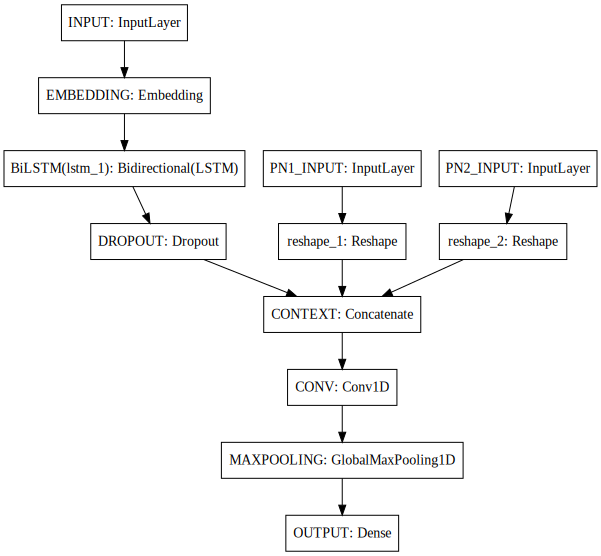

In [236]:
filename = '/Users/lizhn7/Downloads/DATA/semeval2010_task8_all_data/因果关系检测实验/cp_logs/1/weights.012-0.080162.hdf5'
model.load_weights(filename)
result = model.predict([xTest, pn1_xTest, pn2_xTest], batch_size=BATCH_SIZE, verbose=1)

model.summary()

for THRESHOLD in threshold:
    calculate(result, yTest, THRESHOLD)
    print('————————————————————————')
    
SVG(model_to_dot(model).create(prog='dot', format='svg'))

## Experiment 2

2717/2717 [==============================] - 9s     
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
INPUT (InputLayer)           (None, 45)                0         
_________________________________________________________________
EMBEDDING (Embedding)        (None, 45, 300)           7078500   
_________________________________________________________________
BiLSTM (Bidirectional)       (None, 45, 300)           541200    
_________________________________________________________________
DROPOUT (Dropout)            (None, 45, 300)           0         
_________________________________________________________________
CONV (Conv1D)                (None, 45, 128)           115328    
_________________________________________________________________
MAXPOOLING (GlobalMaxPooling (None, 128)               0         
_________________________________________________________________
OUTPUT (Dense)         

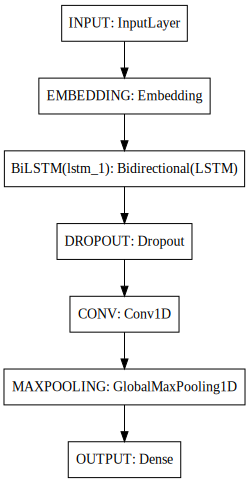

In [234]:
filename = '/Users/lizhn7/Downloads/DATA/semeval2010_task8_all_data/因果关系检测实验/cp_logs/2/weights.008-0.099124.hdf5'
model.load_weights(filename)
result = model.predict(xTest, batch_size=BATCH_SIZE, verbose=1)

model.summary()
SVG(model_to_dot(model).create(prog='dot', format='svg'))

for THRESHOLD in threshold:
    calculate(result, yTest, THRESHOLD)
    print('————————————————————————')
    
SVG(model_to_dot(model).create(prog='dot', format='svg'))

## Experiment 3

2717/2717 [==============================] - 10s    
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
INPUT (InputLayer)               (None, 45)            0                                            
____________________________________________________________________________________________________
EMBEDDING (Embedding)            (None, 45, 300)       7078500     INPUT[0][0]                      
____________________________________________________________________________________________________
PN1_INPUT (InputLayer)           (None, 300)           0                                            
____________________________________________________________________________________________________
BiLSTM (Bidirectional)           (None, 45, 300)       541200      EMBEDDING[0][0]                  
______________________________________

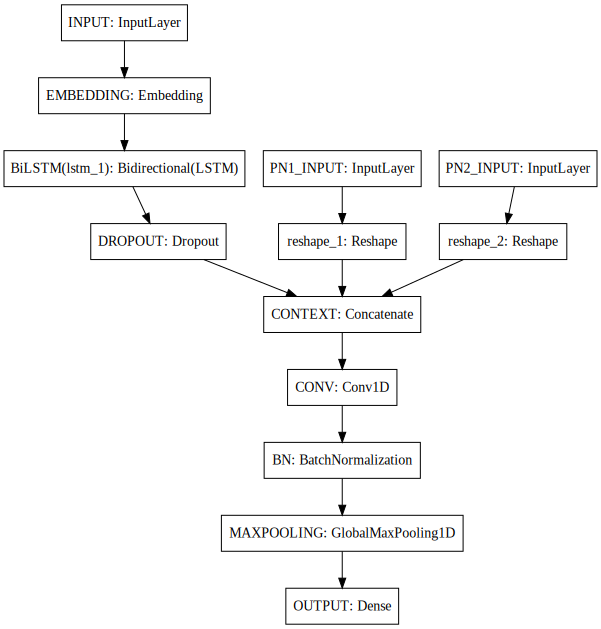

In [268]:
filename = '/Users/lizhn7/Downloads/DATA/semeval2010_task8_all_data/因果关系检测实验/cp_logs/3/weights.006-0.080508.hdf5'
model.load_weights(filename)
result = model.predict([xTest, pn1_xTest, pn2_xTest], batch_size=BATCH_SIZE, verbose=1)

model.summary()

for THRESHOLD in threshold:
    calculate(result, yTest, THRESHOLD)
    print('————————————————————————')
    
SVG(model_to_dot(model).create(prog='dot', format='svg'))